In [1]:
import sys
sys.path.append(".")

# also disable grad to save memory
import torch
torch.set_grad_enabled(False)

DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(DEVICE)
print(torch.__version__)
print(torch.version.cuda)
import yaml
import torch
from omegaconf import OmegaConf
from taming.models.vqgan import VQModel, GumbelVQ
import io
import os, sys
import requests
import PIL
from PIL import Image
from PIL import ImageDraw, ImageFont
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF


cuda:1
1.11.0
11.3


In [2]:
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime
from pprint import pprint
from pysteps import io, nowcasts, rcparams
from pysteps.motion.lucaskanade import dense_lucaskanade
from pysteps.postprocessing.ensemblestats import excprob
from pysteps.utils import conversion, dimension, transformation
from pysteps.visualization import plot_precip_field

Pysteps configuration file found at: /users/junzheyin/anaconda3/envs/myenv/lib/python3.8/site-packages/pysteps/pystepsrc



In [3]:
# Define dataset
import torch
import sys
from nuwa_pytorch import VQGanVAE
import h5py
from PIL import Image
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
def eventGeneration(start_time, obs_time = 3 ,lead_time = 6, time_interval = 30):
    # Generate event based on starting time point, return a list: [[t-4,...,t-1,t], [t+1,...,t+72]]
    # Get the start year, month, day, hour, minute
    year = int(start_time[0:4])
    month = int(start_time[4:6])
    day = int(start_time[6:8])
    hour = int(start_time[8:10])
    minute = int(start_time[10:12])
    #print(datetime(year=year, month=month, day=day, hour=hour, minute=minute))
    times = [(datetime(year, month, day, hour, minute) + timedelta(minutes = time_interval * (x+1))) for x in range(lead_time)]
    lead = [dt.strftime('%Y%m%d%H%M') for dt in times]
    times = [(datetime(year, month, day, hour, minute) - timedelta(minutes = time_interval * x)) for x in range(obs_time)]
    obs = [dt.strftime('%Y%m%d%H%M') for dt in times]
    obs.reverse()
    return lead, obs

from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
from torchvision.transforms import ToTensor, Compose, CenterCrop
class radarDataset(Dataset):
    def __init__(self, root_dir, event_times, obs_number = 3, pred_number = 6, transform=None):
        # event_times is an array of starting time t(string)
        # transform is the preprocessing functions
        self.root_dir = root_dir
        self.transform = transform
        self.event_times = event_times
        self.obs_number = obs_number
        self.pred_number = pred_number
    def __len__(self):
        return len(self.event_times)
    def __getitem__(self, idx):
        start_time = str(self.event_times[idx])
        time_list_pre, time_list_obs = eventGeneration(start_time, self.obs_number, self.pred_number)
        output = []
        time_list = time_list_obs + time_list_pre
        #print(time_list)
        for time in time_list:
            year = time[0:4]
            month = time[4:6]
            #path = self.root_dir + year + '/' + month + '/' + 'RAD_NL25_RAC_MFBS_EM_5min_' + time + '_NL.h5'
            path = self.root_dir + year + '/' + month + '/' + 'RAD_NL25_RAP_5min_' + time + '.h5'
            image = np.array(h5py.File(path)['image1']['image_data'])
            #image = np.ma.masked_where(image == 65535, image)

            image = image[264:520,242:498]
            image[image == 65535] = 0
            image = image.astype('float32')
            image = image/100*12
            image = np.clip(image, 0, 128)
            image = image/40
            output.append(image)
        output = torch.permute(torch.tensor(np.array(output)), (1, 2, 0))
        output = self.transform(np.array(output))
        return output, start_time
#root_dir = '/users/hbi/data/RAD_NL25_RAC_MFBS_EM_5min/'
#dataset = radarDataset(root_dir, ["200808031600"], transform = Compose([ToTensor(),CenterCrop(256)]))


In [5]:
# develop dataset
from torch.cuda.amp import autocast
from torch.autograd import Variable
from torch import optim
import pandas as pd
root_dir = '/home/hbi/RAD_NL25_RAP_5min/' 

# M-L, top 5%
df_train = pd.read_csv('/users/hbi/taming-transformers/training_Delfland08-14.csv', header = None)
event_times = df_train[0].to_list()
dataset_train = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))           

df_test = pd.read_csv('/users/hbi/taming-transformers/testing_Delfland18-20.csv', header = None)
event_times = df_test[0].to_list()
dataset_test = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))

df_vali = pd.read_csv('/users/hbi/taming-transformers/validation_Delfland15-17.csv', header = None)
event_times = df_vali[0].to_list()
dataset_vali = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))

df_train_aa = pd.read_csv('/users/hbi/taming-transformers/training_Aa08-14.csv', header = None)
event_times = df_train_aa[0].to_list()
dataset_train_aa = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))    

df_train_dw = pd.read_csv('/users/hbi/taming-transformers/training_Dwar08-14.csv', header = None)
event_times = df_train_dw[0].to_list()
dataset_train_dw = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))   

df_train_re = pd.read_csv('/users/hbi/taming-transformers/training_Regge08-14.csv', header = None)
event_times = df_train_re[0].to_list()
dataset_train_re = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))    

# extreme, top 1%
df_train_ext = pd.read_csv('/users/hbi/taming-transformers/training_Delfland08-14_ext.csv', header = None)
event_times = df_train_ext[0].to_list()
mfbs = df_train_ext[1].to_list()
dic_mfbs1 = dict(zip(event_times, mfbs))
dataset_train_ext = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))           

df_test_ext = pd.read_csv('/users/hbi/taming-transformers/testing_Delfland18-20_ext.csv', header = None)
event_times = df_test_ext[0].to_list()
mfbs = df_test_ext[1].to_list()
dic_mfbs2 = dict(zip(event_times, mfbs))
dataset_test_ext = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))

df_vali_ext = pd.read_csv('/users/hbi/taming-transformers/validation_Delfland15-17_ext.csv', header = None)
event_times = df_vali_ext[0].to_list()
mfbs = df_vali_ext[1].to_list()
dic_mfbs3 = dict(zip(event_times, mfbs))
dataset_vali_ext = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))

dic_mfbs = {}
dic_mfbs.update(dic_mfbs1)
dic_mfbs.update(dic_mfbs2)
dic_mfbs.update(dic_mfbs3)
new_valid = ['201606222325', '201508131920', '201606230050', '201606230100', '201606230200', '201508261735', '201508261800', '201708300255', '201708300300', '201707291755', '201707291800', '201606201210', '201708300155', '201606230300', '201707120520', '201707120600', '201707120455', '201708300055', '201707120700', '201605301745', '201509041820', '201605301800', '201709081725', '201606201300', '201708300420', '201709081650', '201509041755', '201709081545', '201709081455', '201709141200', '201709141155', '201709081800', '201508132000', '201707062000', '201707061955', '201711270745', '201709141300', '201709141055', '201605301655', '201709081900', '201708300500', '201805291515', '202006171920', '201805291455', '201809050545', '202006171855', '201809050600', '201906150240', '201906150300', '202008161555', '202008161600', '201805291600', '202006122025', '201906150155', '201906120820', '201906052100', '202006171755', '201906120755', '201808242240', '201804292310', '201906120940', '202007252055', '201804292255', '201808242300', '202007252100', '201906121000', '202006172000', '201809050700', '202002091830', '202009232020', '201808101930', '201808242050', '201906150400', '201808242100', '202002091900', '202006050545', '201910210430', '202007251955', '201808102000', '201804102045', '201804300000', '201804102100', '201906052200', '201808101820', '202006050600', '201810300150', '201906052300', '201810300200', '201804102200', '201808101755', '201910061250', '201810300300', '202009232100']
new_valid.sort()
#new_valid = new_valid[41:]
#print(new_valid)
        
dataset_ext = radarDataset(root_dir, new_valid, transform = Compose([ToTensor()])) 

#print("Extreme:", len(dataset_train_ext), len(dataset_test_ext), len(dataset_vali_ext))
loaders = { 'test' :DataLoader(dataset_test_ext, batch_size=1, shuffle=True, num_workers=8), 
           'valid' :DataLoader(dataset_vali, batch_size=1, shuffle=False, num_workers=0),
            'ext' :DataLoader(dataset_ext, batch_size=1, shuffle=False, num_workers=8),
           'train_ext' :DataLoader(dataset_train_ext, batch_size=1, shuffle=True, num_workers=8),
           'train_aa5' :DataLoader(dataset_train_aa, batch_size=1, shuffle=False, num_workers=0),
           'train_del5' :DataLoader(dataset_train, batch_size=1, shuffle=True, num_workers=0),
           'train_dw5' :DataLoader(dataset_train_dw, batch_size=1, shuffle=False, num_workers=0),
           'train_re5' :DataLoader(dataset_train_re, batch_size=1, shuffle=False, num_workers=0)}
print(len(dataset_test_ext))
print(len(dataset_ext))
#print(len(loaders['ext']))
#print(dataset_ext[0])

823
93


In [6]:
from pysteps import motion
from pysteps.visualization import plot_precip_field, quiver
from pysteps.utils import transformation
from pysteps import nowcasts

('201508131920',)
images size are: torch.Size([1, 9, 256, 256])
image size are: torch.Size([9, 256, 256])
(9, 256, 256)
(3, 256, 256)


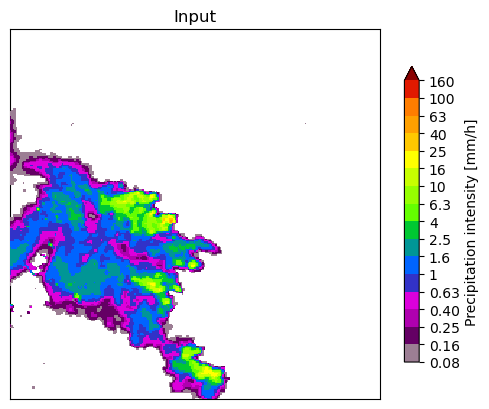

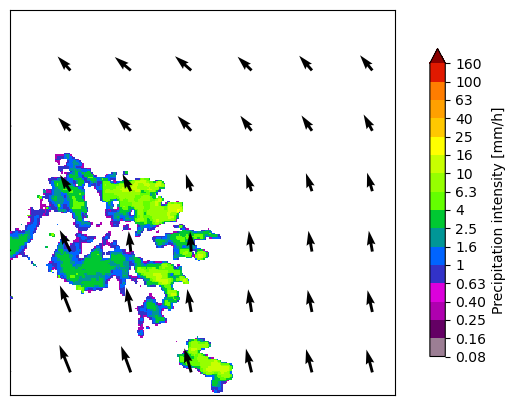

(6, 256, 256)


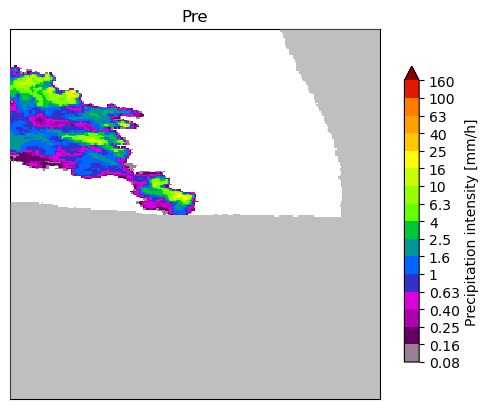

('201508132000',)
images size are: torch.Size([1, 9, 256, 256])
image size are: torch.Size([9, 256, 256])
(9, 256, 256)
(3, 256, 256)


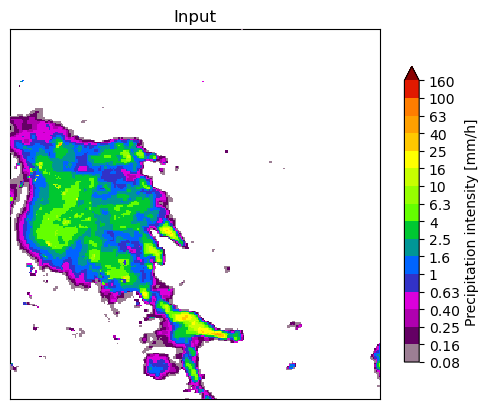

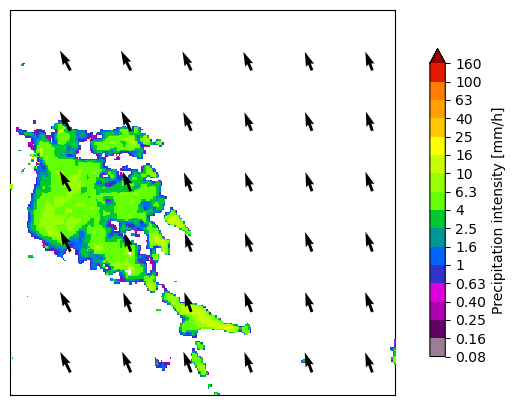

(6, 256, 256)


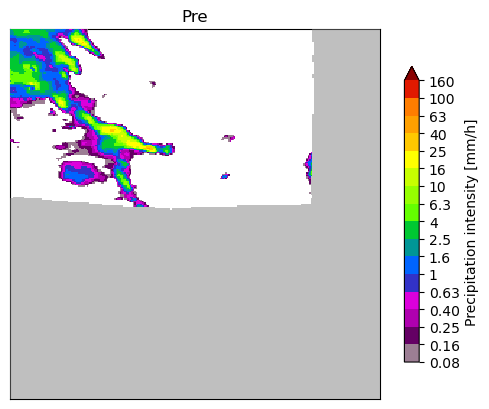

('201508261735',)
images size are: torch.Size([1, 9, 256, 256])
image size are: torch.Size([9, 256, 256])
(9, 256, 256)
(3, 256, 256)


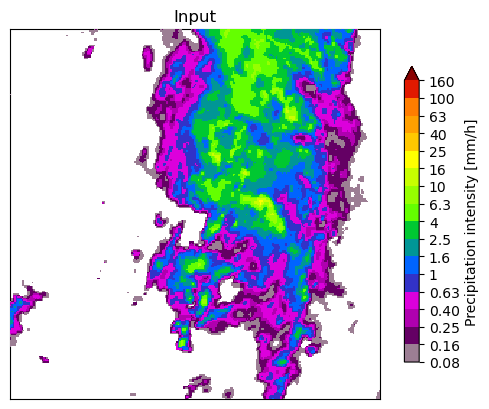

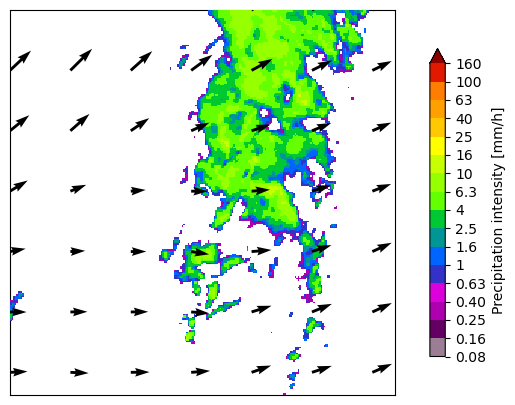

(6, 256, 256)


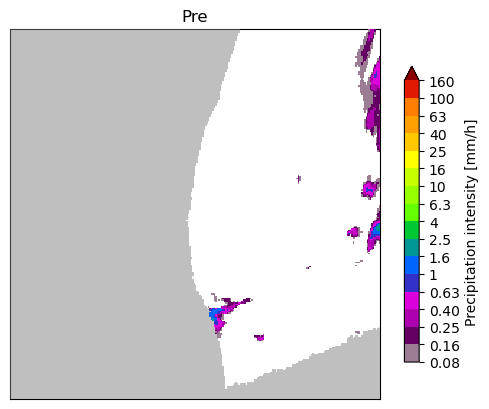

('201508261800',)
images size are: torch.Size([1, 9, 256, 256])
image size are: torch.Size([9, 256, 256])
(9, 256, 256)
(3, 256, 256)


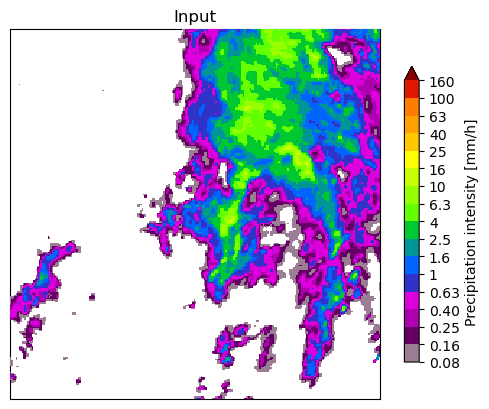

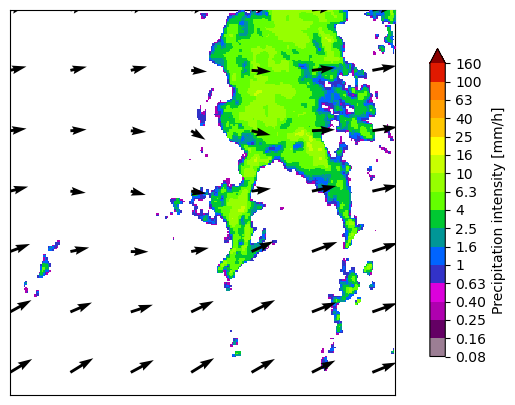

(6, 256, 256)


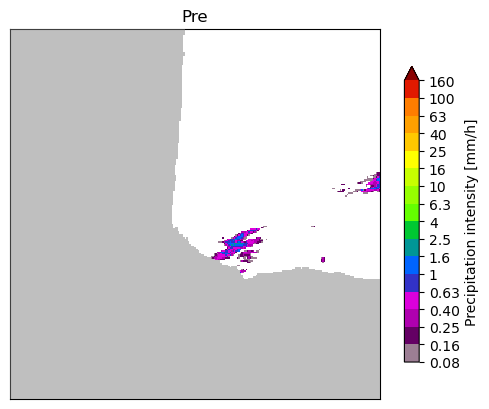

('201509041755',)
images size are: torch.Size([1, 9, 256, 256])
image size are: torch.Size([9, 256, 256])
(9, 256, 256)
(3, 256, 256)


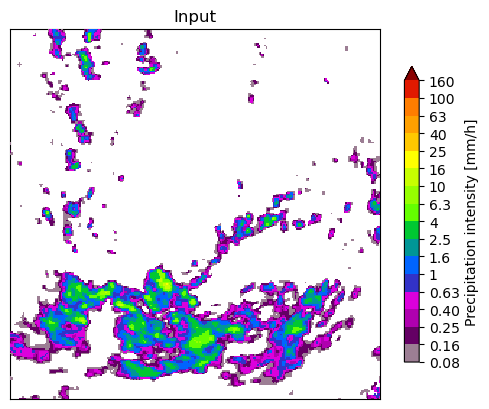

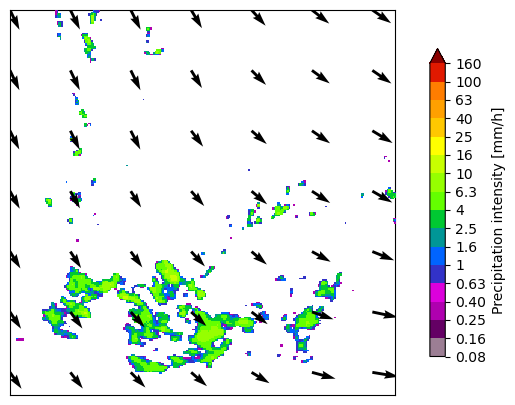

(6, 256, 256)


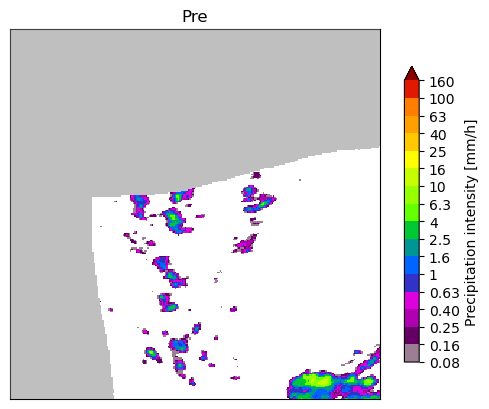

('201509041820',)
images size are: torch.Size([1, 9, 256, 256])
image size are: torch.Size([9, 256, 256])
(9, 256, 256)
(3, 256, 256)


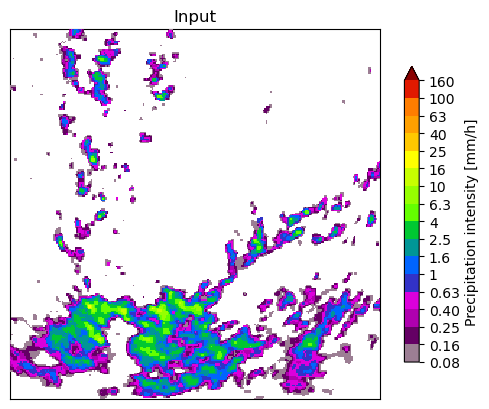

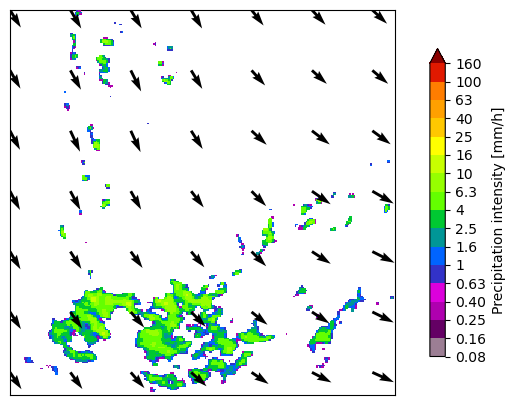

(6, 256, 256)


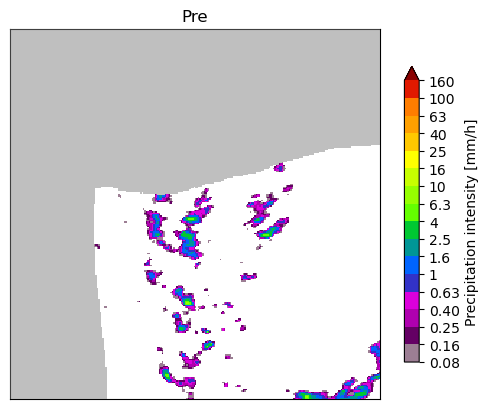

In [9]:

device = torch.device('cpu')
for i, (images,time) in enumerate(loaders['ext']):
    if i<0:continue
    if i>=6:break
    print(time)
    print("images size are:",images.size())
    for image in images:
        image = image.squeeze(2).to(device)
        print("image size are:",image.size())
        a = Variable(image).to(device)   # batch x
        a_np = a.cpu().numpy()*40
        print(a_np.shape)
        R = a_np[-3:, :, :]
        print(R.shape)
        R= transformation.dB_transform(R, metadata=None, threshold=None, zerovalue=None)
        R = R[0]
        plot_precip_field(a_np[-1,:,:], title="Input")
        plt.show()
        oflow_method = motion.get_method("LK")
        motion_field = oflow_method(R)
        plt.figure(figsize=(9, 5), dpi=100)
        plt.title("Estimated motion field with the Lukas-Kanade algorithm")
        plot_precip_field(R[-1], axis="off")
        quiver(motion_field,  step=40)
        plt.show()
        extrapolate = nowcasts.get_method("extrapolation")
        last_observation = R[-1]
        precip_forecast = extrapolate(R[-1], motion_field, 6)
        print(precip_forecast.shape)
        precip_forecast = transformation.dB_transform(precip_forecast, threshold=-10.0, inverse=True)[0]
        plot_precip_field(precip_forecast[-1], title="Pre")
        plt.show()

('201508131920',)
torch.Size([9, 256, 256])
(9, 256, 256)
(3, 256, 256)


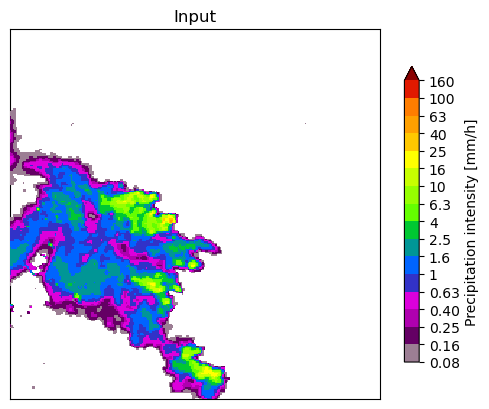

(3, 256, 256)
(2, 256, 256)
Computing S-PROG nowcast
------------------------

Inputs
------
input dimensions: 256x256

Methods
-------
extrapolation:          semilagrangian
bandpass filter:        gaussian
decomposition:          fft
conditional statistics: no
probability matching:   cdf
FFT method:             numpy
domain:                 spatial

Parameters
----------
number of time steps:     6
parallel threads:         1
number of cascade levels: 6
order of the AR(p) model: 2
precip. intensity threshold: -10.0
************************************************
* Correlation coefficients for cascade levels: *
************************************************
-----------------------------------------
| Level |     Lag-1     |     Lag-2     |
-----------------------------------------
| 1     | 0.973635      | 0.915429      |
-----------------------------------------
| 2     | 0.655404      | 0.388375      |
-----------------------------------------
| 3     | 0.450347      | 0.107791  

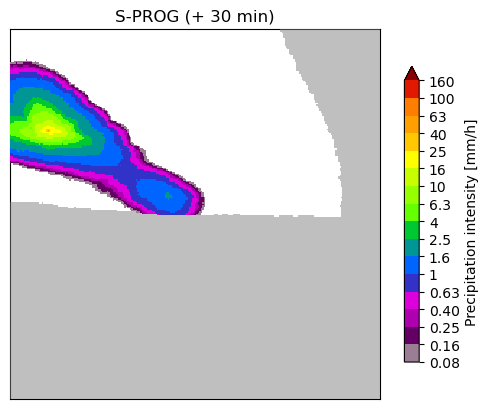

('201508132000',)
torch.Size([9, 256, 256])
(9, 256, 256)
(3, 256, 256)


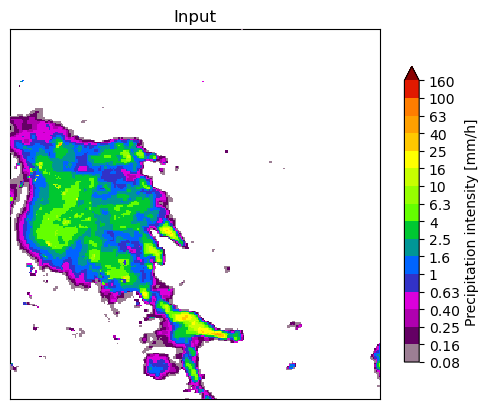

(3, 256, 256)
(2, 256, 256)
Computing S-PROG nowcast
------------------------

Inputs
------
input dimensions: 256x256

Methods
-------
extrapolation:          semilagrangian
bandpass filter:        gaussian
decomposition:          fft
conditional statistics: no
probability matching:   cdf
FFT method:             numpy
domain:                 spatial

Parameters
----------
number of time steps:     6
parallel threads:         1
number of cascade levels: 6
order of the AR(p) model: 2
precip. intensity threshold: -10.0
************************************************
* Correlation coefficients for cascade levels: *
************************************************
-----------------------------------------
| Level |     Lag-1     |     Lag-2     |
-----------------------------------------
| 1     | 0.990379      | 0.961293      |
-----------------------------------------
| 2     | 0.892652      | 0.651855      |
-----------------------------------------
| 3     | 0.538806      | 0.214175  

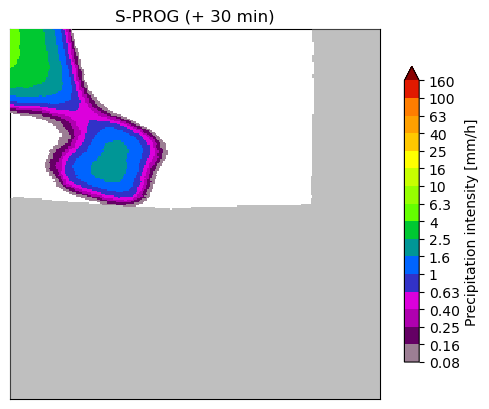

In [25]:
n_ens_members = 20
n_leadtimes = 6
timestep = 5
seed = 24
device = torch.device('cpu')
for i, (images,time) in enumerate(loaders['ext']):
    if i<0:continue
    if i>=2:break
    print(time)
    for image in images:
        image = image.squeeze(2).to(device)
        pprint(image.size())
        a = Variable(image).to(device)   # batch x
        a_np = a.cpu().numpy()*40
        print(a_np.shape)
        R = a_np[-3:, :, :]
        print(R.shape)
        R= transformation.dB_transform(R, metadata=None,  threshold=0.1, zerovalue=-15.0)
        R = R[0]
        #R[~np.isfinite(R)] = -15.0
        plot_precip_field(a_np[-1,:,:], title="Input")
        plt.show()
        V = dense_lucaskanade(R)
        print(R.shape)
        print(V.shape)
# The S-PROG nowcast
        nowcast_method = nowcasts.get_method("sprog")
        R_f = nowcast_method(
            R,
            V,
            n_leadtimes,
            n_cascade_levels=6,
            R_thr=-10.0,
        )

# Back-transform to rain rate
        R_f = transformation.dB_transform(R_f, threshold=-10.0, inverse=True)[0]
        print(R_f.shape)
# Plot the S-PROG forecast
        plot_precip_field(R_f[-1, :, :],title="S-PROG (+ %i min)" % (n_leadtimes * timestep),)
        plt.show()

('201508131920',)
torch.Size([9, 256, 256])
(9, 256, 256)
(3, 256, 256)


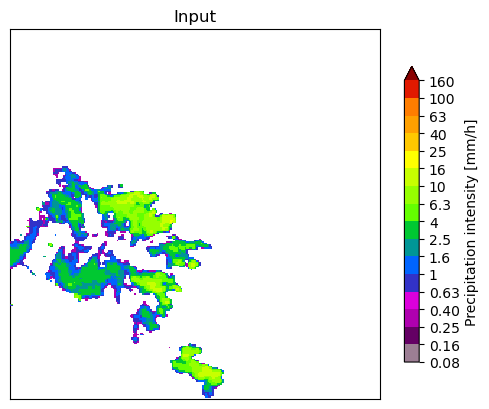

(3, 256, 256)
(2, 256, 256)
Computing STEPS nowcast
-----------------------

Inputs
------
input dimensions: 256x256
km/pixel:         2.0
time step:        6 minutes

Methods
-------
extrapolation:          semilagrangian
bandpass filter:        gaussian
decomposition:          fft
noise generator:        nonparametric
noise adjustment:       no
velocity perturbator:   bps
conditional statistics: no
precip. mask method:    incremental
probability matching:   cdf
FFT method:             numpy
domain:                 spatial

Parameters
----------
number of time steps:     5
ensemble size:            20
parallel threads:         1
number of cascade levels: 6
order of the AR(p) model: 2
velocity perturbations, parallel:      10.88,0.23,-7.68
velocity perturbations, perpendicular: 5.76,0.31,-2.72
precip. intensity threshold: -10.0
************************************************
* Correlation coefficients for cascade levels: *
************************************************
-------------

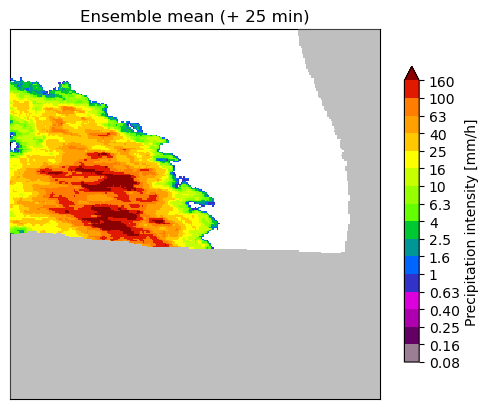

('201508132000',)
torch.Size([9, 256, 256])
(9, 256, 256)
(3, 256, 256)


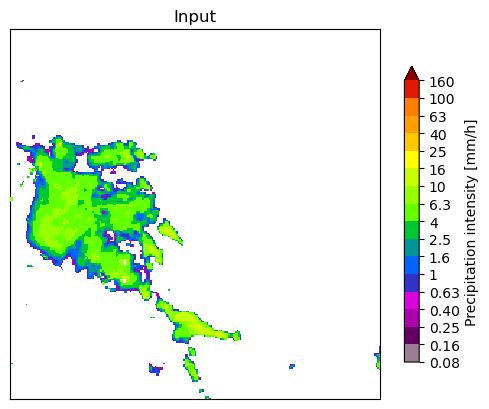

(3, 256, 256)
(2, 256, 256)
Computing STEPS nowcast
-----------------------

Inputs
------
input dimensions: 256x256
km/pixel:         2.0
time step:        6 minutes

Methods
-------
extrapolation:          semilagrangian
bandpass filter:        gaussian
decomposition:          fft
noise generator:        nonparametric
noise adjustment:       no
velocity perturbator:   bps
conditional statistics: no
precip. mask method:    incremental
probability matching:   cdf
FFT method:             numpy
domain:                 spatial

Parameters
----------
number of time steps:     5
ensemble size:            20
parallel threads:         1
number of cascade levels: 6
order of the AR(p) model: 2
velocity perturbations, parallel:      10.88,0.23,-7.68
velocity perturbations, perpendicular: 5.76,0.31,-2.72
precip. intensity threshold: -10.0
************************************************
* Correlation coefficients for cascade levels: *
************************************************
-------------

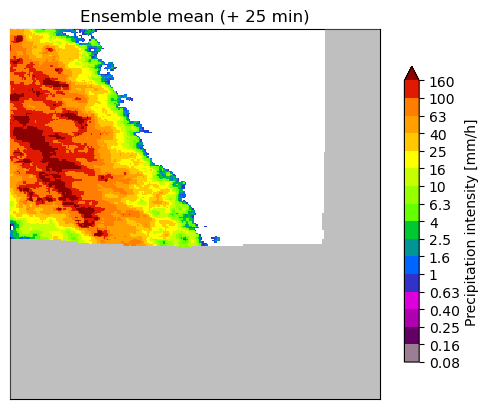

In [18]:
n_ens_members = 20
n_leadtimes = 5
seed = 24
device = torch.device('cpu')
for i, (images,time) in enumerate(loaders['ext']):
    if i<0:continue
    if i>=2:break
    print(time)
    for image in images:
        image = image.squeeze(2).to(device)
        pprint(image.size())
        a = Variable(image).to(device)   # batch x
        a_np = a.cpu().numpy()*40
        print(a_np.shape)
        R = a_np[-3:, :, :]
        print(R.shape)
        R= transformation.dB_transform(R, metadata=None, threshold=None, zerovalue=None)
        R = R[0]
        #R[~np.isfinite(R)] = -15.0
        plot_precip_field(R[-1,:,:], title="Input")
        plt.show()
        V = dense_lucaskanade(R)
        print(R.shape)
        print(V.shape)
        nowcast_method = nowcasts.get_method("steps")
        R_f = nowcast_method(
            R,
            V,
            n_leadtimes,
            n_ens_members,
            n_cascade_levels=6,
            R_thr=-10.0,
            kmperpixel=2.0,
            timestep=6,
            noise_method="nonparametric",
            vel_pert_method="bps",
            mask_method="incremental",
            seed=seed,
        )
        R_f = transformation.dB_transform(R_f, threshold=None, inverse=True)[0]


# Plot the ensemble mean
        R_f_mean = np.mean(R_f[-1, :, :], axis=0)*40
        plot_precip_field(R_f_mean,title="Ensemble mean (+ %i min)" % (n_leadtimes * 5),)
        plt.show()